#### The DIO files
The DIO files are digital input-output files from the digital input-output board. The inputs to the DIO board are infrared sensors that detect motion near the reward well (sensor is an infrared beam placed above the well that is interrupted when the animal passes through it) and trigger automatic delivery of reward. The DIO files are formatted as {*animal*}DIO{*day*}.mat. This notebook is an attempt to figure out how the data is formatted in the DIO files.

##### DIO .mat Variables
Each Matlab file has three Matlab-cells: *DIO*, *rawdio*, and *diopulses*. For the *DIO* and *rawdio* Matlab-cells, the data structure is nested in Matlab-cells {*day*}{*epoch*}{*pins*}. For the *diopulses* Matlab-cell, the structure is nested as {*pins*}. Pins are digital pins that can be configured as an input or an output. Inactive pins are empty cells. Active pins contain Matlab-structures.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 3
import sys
import collections
import scipy.io
import numpy as np
import matplotlib.pyplot as plt  
import seaborn as sns

sys.path.append('../src/')
import data_filter as df

# Get an example DIO file assuming the data is in the Raw Data folder
Animal = collections.namedtuple('Animal', {'directory', 'short_name'})
HPa = Animal(directory='HPa_direct', short_name='HPa')
day = 8

dio_file = df.get_data_filename(HPa, day, 'DIO')

# Load .mat file
print('DIO file: {file}'.format(file=dio_file))
DIO = scipy.io.loadmat(dio_file)

# Make sure all the Matlab-cells exist and are the right size
print('DIO size: {size}'.format(size=DIO['DIO'].shape))
assert(DIO['DIO'].shape[1] == day)

print('rawdio size: {size}'.format(size=DIO['rawdio'].shape))
assert(DIO['rawdio'].shape[1] == day)

print('diopulses size: {size}'.format(size=DIO['diopulses'].shape))

ERROR: Line magic function `%autoreload` not found.


DIO file: /Users/edeno/Documents/GitHub/Jadhav-2016-Data-Analysis/Raw-Data/HPa_direct/HPaDIO08.mat
DIO size: (1, 8)
rawdio size: (1, 8)
diopulses size: (1, 24)


Let's look at one animal (*HPa*). The animal is running on the first w-track environment (*wtr1*) over eight days, for multiple sessions per day. Position is indicated by the blue lines.

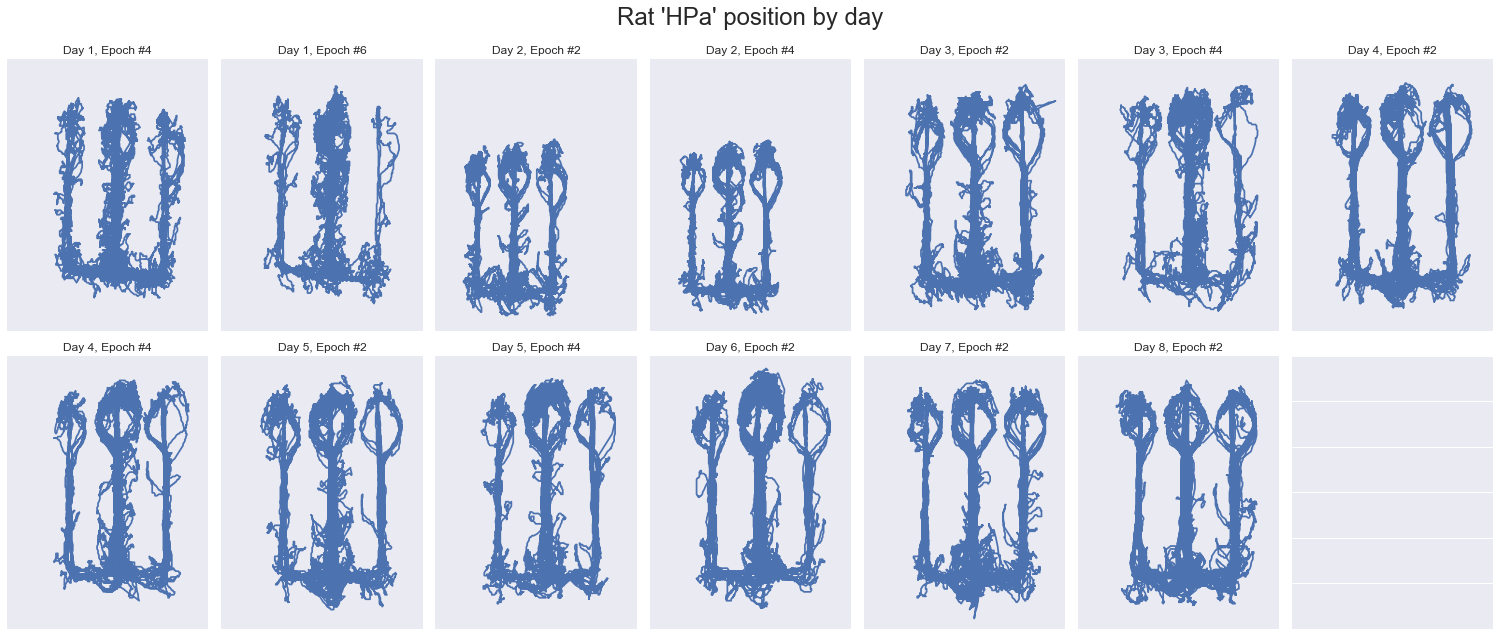

In [2]:
HPa = Animal(directory='HPa_direct', short_name='HPa')
epoch_type = 'run'
environment = 'wtr1'
num_days = 8
days = range(1, num_days + 1)


def plot_epoch_positions(ax, position_data, epoch_data):
    '''Given an axis handle, position data array, and an epoch tuple, plot all
    positions run by the animal for that epoch'''
    ax.plot(position_data[:, 0], position_data[:, 1])
    ax.set_title('Day {day}, Epoch #{epoch}'.format(day=epoch_data[1], epoch=epoch_data[2] + 1))
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)

def plot_all_positions(animal, days, epoch_type=epoch_type, environment=environment):
    '''Plots the position over all epochs specified by the animal, days, epoch_type,
    and environment.
    '''
    position = df.get_position_variables(animal, days, ['x', 'y'], epoch_type=epoch_type, environment=environment)
    epochs = df.get_epochs(animal, days, epoch_type=epoch_type, environment=environment)
    num_rows = int(np.ceil(len(epochs) / 7))
    fig, axis_handles = plt.subplots(num_rows, 7, figsize=(21, 9), sharex=True, sharey=True)
    for epoch_ind, axis_handle in enumerate(axis_handles.flatten()):
        try:
            plot_epoch_positions(axis_handle, position[epoch_ind], epochs[epoch_ind])
        except IndexError:
            axis_handle.xaxis.set_visible(False)

    plt.tight_layout()
    plt.subplots_adjust(top=0.90)
    plt.suptitle("Rat '{animal}' position by day".format(animal=animal.short_name), fontsize=24)
    sns.set_style("dark")
    return fig, axis_handles


plot_handles = plot_all_positions(HPa, days, epoch_type=epoch_type, environment=environment)

Now let's match the pulse times from the DIO inputs to the rat's position (red dots are the rat's position when there is a pulse). The positions should correspond to the ends of the three arms -- the position of the food wells.

(Animal(short_name='HPa', directory='HPa_direct'), 8, 1)


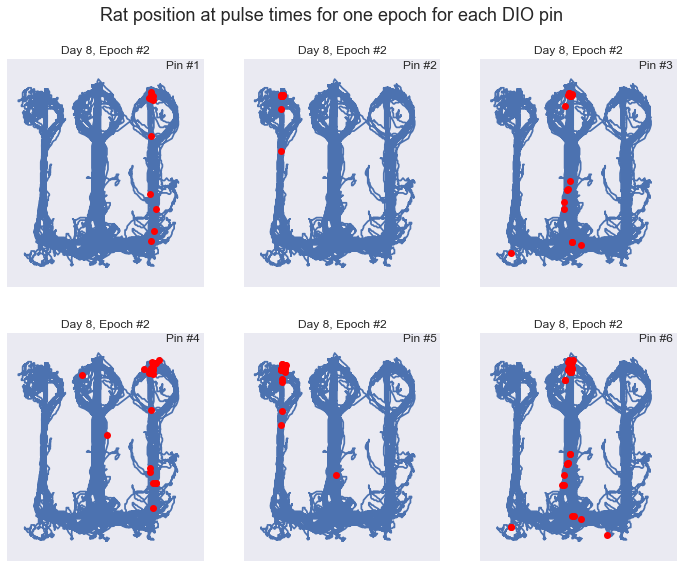

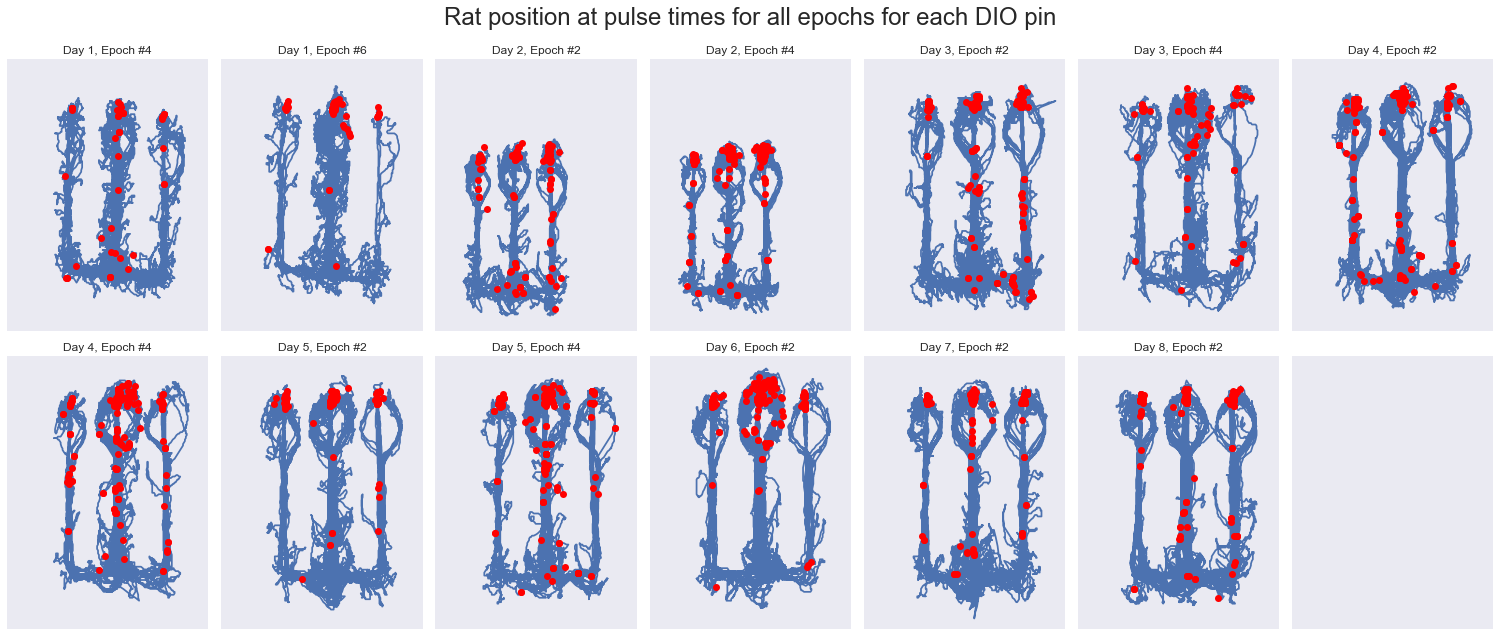

In [3]:
pulse_times = df.get_DIO_variable(HPa, days, 'pulsetimes', epoch_type=epoch_type, environment=environment)
position = df.get_position_variables(HPa, days, ['time', 'x', 'y'], epoch_type=epoch_type, environment=environment)
epochs = df.get_epochs(HPa, days, epoch_type=epoch_type, environment=environment)

assert(len(pulse_times) == len(position))


def plot_pin_position(axis_handle, position, pulse_position_ind, pin_number):
    axis_handle.plot(
        position[pulse_position_ind, 1],
        position[pulse_position_ind, 2],
        'ro',
        label='Pin #{pin_number}'.format(pin_number=pin_number))


# Plot one epoch
epoch_ind = 12;
print(epochs[epoch_ind])
pulse_position_ind = df.get_pulse_position_ind(pulse_times[epoch_ind], position[epoch_ind][:, 0])
_, axis_handles = plt.subplots(2, 3, figsize=(12, 9))

for pin_ind, axis_handle in enumerate(axis_handles.flatten()):
    plot_epoch_positions(axis_handle, position[epoch_ind][:, [1,2]], epochs[epoch_ind])
    plot_pin_position(axis_handle, position[epoch_ind], pulse_position_ind[pin_ind], pin_ind + 1)
    _, xmax = axis_handle.get_xlim()
    _, ymax = axis_handle.get_ylim()
    axis_handle.text(xmax - 23, ymax - 5, 'Pin #{pin_number}'.format(pin_number=pin_ind + 1))
    
plt.subplots_adjust(top=0.90)
plt.suptitle('Rat position at pulse times for one epoch for each DIO pin', fontsize=18)
    
# Plot all epochs
fig, axis_handles = plot_all_positions(HPa, days, epoch_type=epoch_type, environment=environment)
for epoch_ind, axis_handle in enumerate(axis_handles.flatten()):
    try:
        pulse_position_ind = df.get_pulse_position_ind(pulse_times[epoch_ind], position[epoch_ind][:, 0])
        for pin_ind in range(0,6):
            plot_pin_position(axis_handle, position[epoch_ind], pulse_position_ind[pin_ind], pin_ind + 1)
    except:
        axis_handle.xaxis.set_visible(False)
        
plt.suptitle('Rat position at pulse times for all epochs for each DIO pin', fontsize=24)

The pulse positions match to the ends of the wells mostly, but there is some variablity down the arms. Pins \#1-3 seem to give similar values to Pins \#4-6, respectively. Since the DIO data structure doesn't always seem to correspond to the food well positions, let's look at the 'rawdio' data structure.

(Animal(short_name='HPa', directory='HPa_direct'), 8, 1)


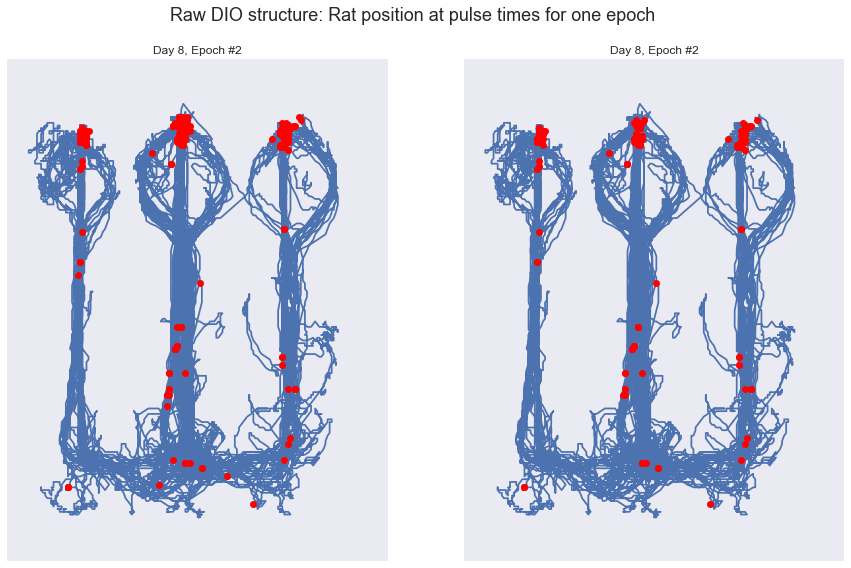

In [4]:
raw_dio = df.get_data_structure(HPa, days, 'DIO', 'rawdio', epoch_type=epoch_type, environment=environment)
TIME_CONSTANT = 1E4

# Plot one epoch
epoch_ind = 12;
print(epochs[epoch_ind])
pulse_position_ind = df.find_closest_ind(position[epoch_ind][:, 0], 
                                         raw_dio[epoch_ind]['times'][0,0][:, 0] / TIME_CONSTANT)

_, axis_handle = plt.subplots(1, 2, figsize=(15, 9))
plot_epoch_positions(axis_handle[0], position[epoch_ind][:, [1,2]], epochs[epoch_ind])
plot_pin_position(axis_handle[0], position[epoch_ind], pulse_position_ind, 0)
_, xmax = axis_handle[0].get_xlim()
_, ymax = axis_handle[0].get_ylim()
    
plt.subplots_adjust(top=0.90)
plt.suptitle('Raw DIO structure: Rat position at pulse times for one epoch', fontsize=18)

pulse_position_ind = df.get_pulse_position_ind(pulse_times[epoch_ind], position[epoch_ind][:, 0])
plot_epoch_positions(axis_handle[1], position[epoch_ind][:, [1,2]], epochs[epoch_ind])
for pin_ind in range(0,6):
    plot_pin_position(axis_handle[1], position[epoch_ind], pulse_position_ind[pin_ind], pin_ind + 1)